In [1]:
%matplotlib inline

# Datasets and Dataloaders｜数据集和数据加载器

处理数据样本的代码可能会变得混乱且难以维护；我们理想地想要我们的数据集代码
与我们的模型训练代码分离，以获得更好的可读性和模块化。
PyTorch 提供了两种数据原语：``torch.utils.data.DataLoader`` 和``torch.utils.data.Dataset``
允许您使用预加载的数据集以及您自己的数据。
``Dataset`` 存储样本及其相应的标签，``DataLoader`` 包装了一个可迭代对象
``Dataset`` 可以轻松访问样本。

PyTorch 域库提供了许多预加载的数据集（例如 FashionMNIST），这些数据集
子类 ``torch.utils.data.Dataset`` 并实现特定于特定数据的功能。
它们可用于对您的模型进行原型设计和基准测试。你可以找到他们
此处：[图像数据集](https://pytorch.org/vision/stable/datasets.html)，
[文本数据集](https://pytorch.org/text/stable/datasets.html)，和
[音频数据集](https://pytorch.org/audio/stable/datasets.html)

## 加载数据集

以下是如何从 TorchVision 加载 [Fashion-MNIST](https://research.zalando.com/welcome/mission/research-projects/fashion-mnist/) 数据集的示例。
Fashion-MNIST 是 Zalando 文章图像的数据集，由 60,000 个训练示例和 10,000 个测试示例组成。
每个示例包含一个 28×28 灰度图像和来自 10 个类别之一的相关标签。

我们使用以下参数加载 [FashionMNIST 数据集](https://pytorch.org/vision/stable/datasets.html#fashion-mnist)：
 - `root` 是存储训练/测试数据的路径，
 - `train` 指定训练或测试数据集，
 - `download=True` 从 Internet 下载数据，如果它在 `root` 下不可用。
 - `transform` 和 `target_transform` 指定特征和标签转换

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100.0%

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw


111.0%

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw


100.0%

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw


159.1%

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw
Processing...
Done!


迭代和可视化数据集
-----------------

我们可以像列表一样手动索引“数据集”：“training_data[index]”。
我们使用“matplotlib”来可视化训练数据中的一些样本。



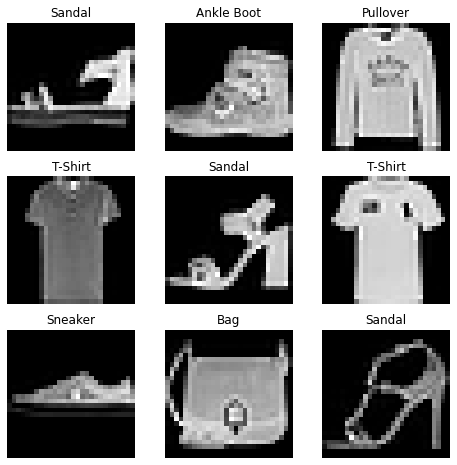

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

为您的文件创建自定义数据集
-------------------------------------------------- ——

自定义 Dataset 类必须实现三个函数：`__init__`、`__len__` 和 `__getitem__`。
看看这个实现； FashionMNIST 图像被存储
在目录 img_dir 中，它们的标签分别存储在 CSV 文件 annotations_file 中。

在接下来的部分中，我们将分解每个函数中发生的事情。



In [4]:
import os
import pandas as pd
import torchvision.io as tvio

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = tvio.read_image(img_path)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        sample = {"image": image, "label": label}
        return sample

## init

`__init__` 函数在实例化 Dataset 对象时运行一次。 我们初始化
包含图像、注释文件和两个转换的目录（涵盖
在下一节中更详细）。

label.csv 文件如下所示：
```

    tshirt1.jpg, 0
    tshirt2.jpg, 0
    ......
    ankleboot999.jpg, 9
```
Example:
```
def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform
```

## len

`__len__` 函数返回我们数据集中的样本数。

Example:
```
def __len__(self):
    return len(self.img_labels)
```


## getitem

`__getitem__` 函数从给定索引 `idx` 的数据集中加载并返回一个样本。
基于索引，它识别图像在磁盘上的位置，使用 `read_image` 将其转换为张量，检索
来自 `self.img_labels` 中的 csv 数据的相应标签，对其调用变换函数（如果适用），并返回
Python `dict` 中的张量图像和相应标签。

Example:
```
def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
        image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    sample = {"image": image, "label": label}
    return sample
```

准备数据以使用 DataLoaders 进行训练
-------------------------------------------------
``Dataset`` 检索我们数据集的特征并一次标记一个样本。 在训练模型时，我们通常希望
在“小批量”中传递样本，在每个时期重新洗牌数据以减少模型过度拟合，并使用 Python 的“多处理”
加快数据检索。

``DataLoader`` 是一个迭代器，它在一个简单的 API 中为我们抽象了这种复杂性。



In [5]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

## 遍历 DataLoader

我们已经将该数据集加载到 `Dataloader` 中，并且可以根据需要遍历数据集。
下面的每次迭代都会返回一批 `train_features` 和 `train_labels`（分别包含 `batch_size=64` 特征和标签）。 因为我们指定了`shuffle=True`，所以在我们遍历所有批次后，数据被打乱（为了更细粒度地控制数据加载顺序，请查看[Samplers](https://pytorch.org/docs/stable /data.html#data-loading-order-and-sampler>)。



Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


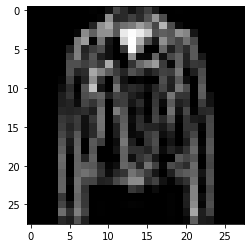

Label: 4


In [6]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")